# Cube+ dataset metric

In [1]:
import torch
import numpy as np
import os
import model.paper_alexnet as fc4_model
import evaluation.metrics as metrics
import  random
import os
import cv2
import matplotlib.pyplot as plt



def test(image,illum,index,net):
    net.eval()
    images = image.to("cuda:0").type(torch.cuda.FloatTensor)
    illums = illum.to("cuda:0").type(torch.cuda.FloatTensor)
    index = index.to("cuda:0").type(torch.cuda.FloatTensor)
    domain_output, preds,pred_common = net(images,index, 0,0)
    
    loss = metrics.angle_loss(preds, illums)
    return loss.item(),preds

camera = ["Canon1D", "Canon5D", "Canon1DsMkIII", "Canon600D", "FujifilmXM1",
          "NikonD5200", "OlympusEPL6", "PanasonicGX1", "SamsungNX2000",
          "SonyA57", "Canon550D"]

def load_image(fn):
    if fn.startswith("IMG") or fn.startswith("8D5U"):
        img_path = "/home/***/data/CC/" + fn.split(".")[0]
    else:
        if len(fn.split(".")[0])<5:
            img_path="/home/***/data/Cube"+fn.split(".")[0]
        else:
            img_path="/home/***/data/NUS/"+fn.split(".")[0]

    img = np.load(img_path + ".npy").astype(np.float32)
    mask = np.load(img_path + "_mask.npy").astype(np.bool_)
    gt = np.load(img_path + "_gt.npy").astype(np.float32)
    camera_idx = np.load(img_path + "_camera.npy")
    

    index = camera.index(camera_idx)
    idx1, idx2, _ = np.where(mask == False)
    img[idx1, idx2, :] = 1e-5
    img[img == 0] = 1e-5
    C_index = np.zeros(11)
    C_index[index] = 1
    
    fcn_input_size = (256, 256)
    image = cv2.resize(img, fcn_input_size)
    
    image=image/image.max()
    illum = gt / np.linalg.norm(gt)
    image = np.power(image, 1 / 2.2)  
    image = image.transpose(2, 0, 1)  
    image = torch.from_numpy(image.copy()).unsqueeze(dim=0)  
    illum = torch.from_numpy(illum.copy()).unsqueeze(dim=0)
    C_index=torch.from_numpy(C_index.copy()).unsqueeze(dim=0)
    

    ret = (image, illum, C_index)
    return ret

# dataset and pretrained model

In [2]:
file3="/home/***/python/net3/paper/three_fold_orignal/alexnet/Cube/fold3.txt"
file2="/home/***/python/net3/paper/three_fold_orignal/alexnet/Cube/fold2.txt"
file1="/home/***/python/net3/paper/three_fold_orignal/alexnet/Cube/fold1.txt"

Start3="/home/***/python/net3/paper/three_fold_orignal/alexnet/Cube/fold3.pkl"
Start2="/home/***/python/net3/paper/three_fold_orignal/alexnet/Cube/fold2.pkl"
Start1="/home/***/python/net3/paper/three_fold_orignal/alexnet/Cube/fold1.pkl"
dict_model={file3:Start3,file2:Start2,file1:Start1}

In [4]:
net = fc4_model.CNNModel()
net.to("cuda:0")
error={}
pred_illum={}
for i in range(1,4):
    file="/home/***/python/net3/paper/three_fold_orignal/alexnet/Cube/fold"+str(i)+".txt"
    Start=dict_model[file]
    file_name=[]
    with open(file,"r") as f:
        for line in f:
            fields = line.split()[0]
            fields=fields.split("/")[-1]
            file_name.append(fields)

    data = torch.load(Start)
    net.load_state_dict(data)

    for i in range(len(file_name)):
        name=file_name[i]
        image, illum, C_index=load_image(name)
        rrr,preds=test(image, illum, C_index,net)
        pred_illum[name]=preds.cpu().detach().numpy().flatten()
        error[name]=rrr
        print(name,rrr)
        
angle=[]
for key in error:
    angle.append(error[key])
metrics.metric(angle)

2.PNG 0.09891171753406525
5.PNG 1.4127774238586426
7.PNG 1.3888896703720093
9.PNG 1.0907394886016846
10.PNG 0.6246365904808044
13.PNG 0.11190583556890488
15.PNG 1.5748283863067627
17.PNG 0.8602555990219116
18.PNG 1.012590765953064
19.PNG 0.4302385151386261
22.PNG 1.2797774076461792
24.PNG 0.11534988880157471
27.PNG 0.17913678288459778
28.PNG 0.5524928569793701
29.PNG 5.075820446014404
32.PNG 0.9505930542945862
33.PNG 0.8018627166748047
39.PNG 0.4780632555484772
44.PNG 0.40926113724708557
45.PNG 0.12194657325744629
52.PNG 1.8836711645126343
54.PNG 0.22205635905265808
58.PNG 1.8108891248703003
61.PNG 0.2631871700286865
64.PNG 5.926784515380859
65.PNG 0.23239004611968994
66.PNG 0.8855862021446228
70.PNG 1.1386638879776
71.PNG 1.3386679887771606
73.PNG 0.9189842343330383
74.PNG 0.6546167731285095
75.PNG 2.000173568725586
77.PNG 1.5843677520751953
78.PNG 9.14647388458252
86.PNG 2.7110111713409424
87.PNG 1.4552181959152222
89.PNG 0.6211811900138855
90.PNG 0.6763749122619629
94.PNG 0.49018859

{'mean': 1.2069820663474355,
 'median': 0.7132670879364014,
 'trimean': 0.8218516111373901,
 'best25': 0.19575722952823685,
 'worst25': 3.0654742935502277,
 'pct95': 4.2246568202972385}

# image show

          pred_illum,                             GT_illum,                angle_loss
[0.33395502 0.77215564 0.54060125] [0.33473366 0.77257293 0.53952247] 0.08156468719244003


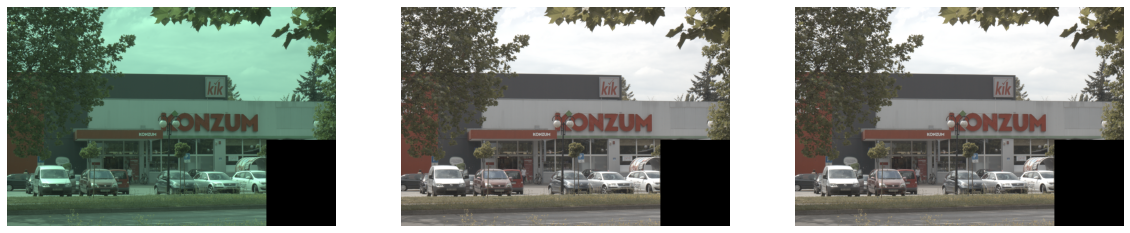

[0.3309032  0.7713088  0.54367805] [0.3285815 0.7690165 0.5483136] 0.3250574469566345


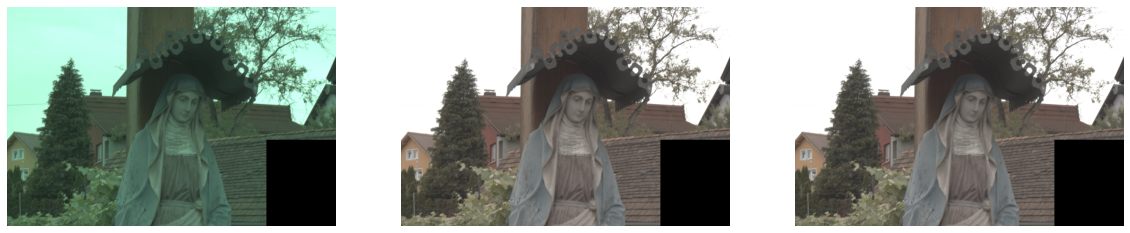

[0.3381433  0.77552176 0.53312767] [0.34268346 0.77716446 0.52781004] 0.4121198058128357


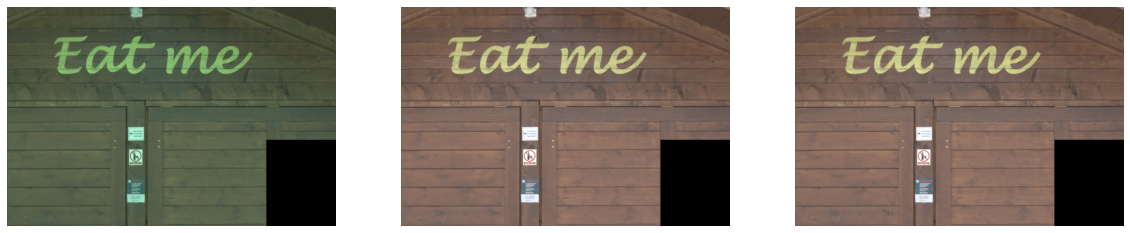

[0.33455956 0.77161574 0.54099834] [0.32044634 0.76439345 0.559479  ] 1.3950753211975098


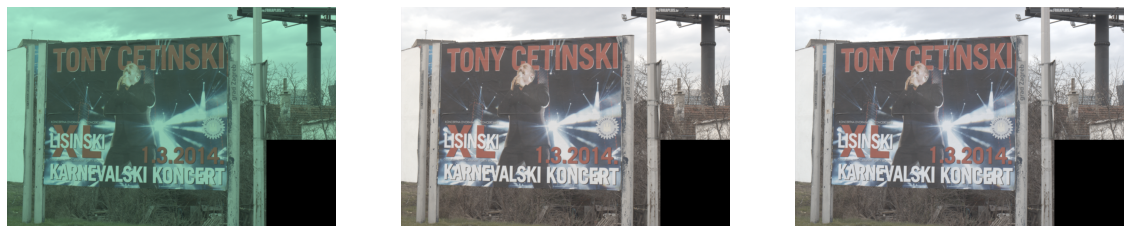

[0.38399607 0.77923656 0.49531558] [0.35786954 0.78172386 0.5107222 ] 1.7437210083007812


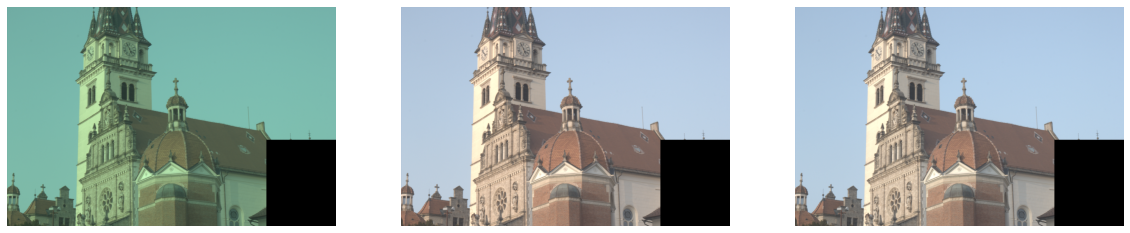

[0.35161674 0.7798922  0.51781636] [0.32352325 0.7656781  0.55594045] 2.8332414627075195


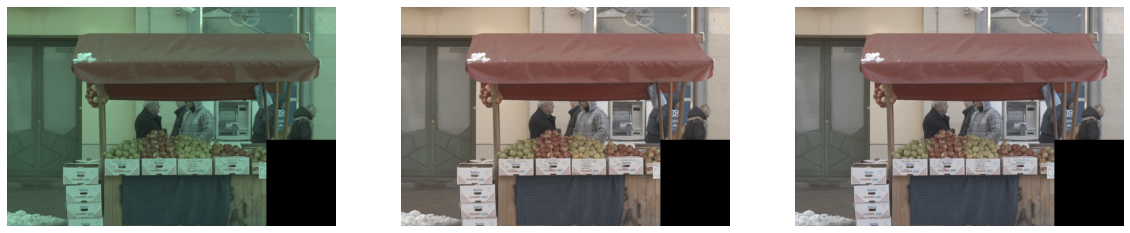

[0.35161674 0.7798922  0.51781636] [0.32352325 0.7656781  0.55594045] 2.8332414627075195


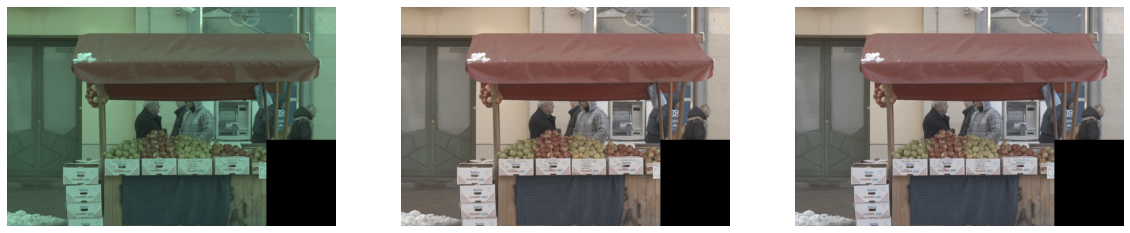

[0.25867867 0.7306192  0.63188684] [0.33276495 0.77038705 0.54384863] 6.979546546936035


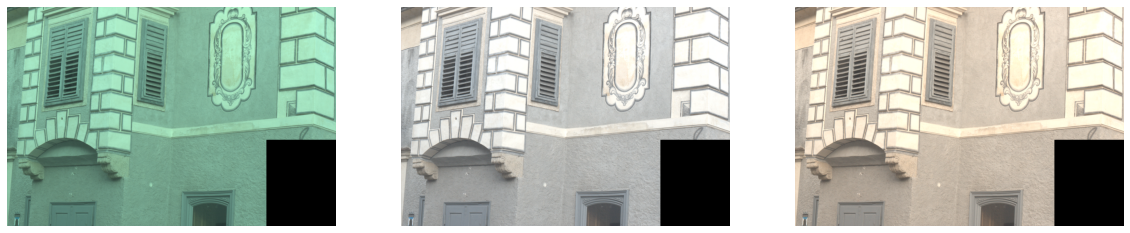

[0.44405457 0.78976154 0.42319295] [0.33473912 0.77352405 0.53815454] 9.14647388458252


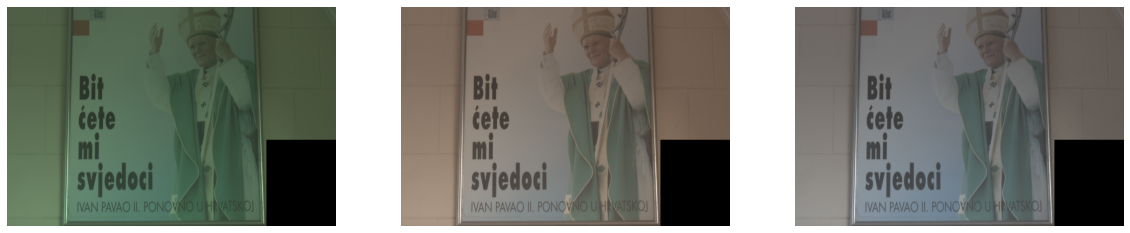

In [45]:
def show_image(fn):
    if fn.startswith("IMG") or fn.startswith("8D5U"):
        img_path = "/home/***/data/CC/" + fn.split(".")[0]
    else:
        if len(fn.split(".")[0])<5:
            img_path="/home/***/data/Cube/"+fn.split(".")[0]
        else:
            img_path="/home/***/data/NUS/"+fn.split(".")[0]

    img = np.load(img_path + ".npy").astype(np.float32)
    mask = np.load(img_path + "_mask.npy").astype(np.bool_)
    gt = np.load(img_path + "_gt.npy").astype(np.float32)

    idx1, idx2, _ = np.where(mask == False)
    img[idx1, idx2, :] = 1e-5
    img[img == 0] = 1e-5
    return img,gt
def norm(illum):
    illum=illum/np.linalg.norm(illum,ord=2)
    return illum
def imshow(img):
    img=np.clip(img,0,1)
    img=np.power(img,1/2.5)
    img=img/img.max()
    return img
    
file_list=["99.PNG","334.PNG","383.PNG","971.PNG","581.PNG","267.PNG","267.PNG","298.PNG","78.PNG"]

print("          pred_illum,                             GT_illum,                angle_loss")
for i in range(len(file_list)):
    show_file=file_list[i]
    img,gt=show_image(show_file)
    pred=pred_illum[show_file]
    gt=norm(gt)
    pred=norm(pred)
    loss=error[show_file]
    print(gt,pred,loss)
    
    img=img/img.max()
    raw=imshow(img)
    pred_img=imshow(img/pred)
    GT_img=imshow(img/gt)
    
    plt.figure(figsize=(20,30))
    plt.subplot(1,3,1)
    plt.imshow(raw)
    plt.axis("off")
    plt.subplot(1,3,2)
    plt.imshow(pred_img)
    plt.axis("off")
    plt.subplot(1,3,3)
    plt.imshow(GT_img)
    plt.axis("off")
    plt.show()